<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



<h1>Curso Ingeniería de Características</h1>

<h3>Datos numéricos</h3>


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="150">
</p>


<a target="_blank" href="https://colab.research.google.com/github/mcd-unison/ing-caract/blob/main/ejemplos/tipos/python/numericos.ipynb"><img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"  width="30" /> Ejecuta en Colab</a>

</center>

In [12]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import urllib.request

## Descargando datos

Para poder descargar los datos que vamos a utilizar, vamos a requerir el módulo de ``kaggle``. Por lo que vamos a [seguir estos pasos](https://www.kaggle.com/general/74235) para usar correctamente la API de Kaggle en Colab.

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Y ahora probamos que todo funciona bien, al ver la lista de datasets
!kaggle datasets list

Y listo, vamos a descargar nuestro conjunto de datos

In [ ]:
!kaggle datasets download 'camnugent/california-housing-prices'


Los datos se encuentran en archivo comprimido, pero es un `csv`, por lo que lo podemos abrir directamente en Pandas.

In [ ]:
df_raw = pd.read_csv("./california-housing-prices.zip")

df_raw.info()

## Explorando los datos

Vamops a ver como se comportan cada una de las variables y para esto vamos a usar diferentes métodos de graficación que vienen incluidos en Pandas.

Lo primero que vamos a hacer va a ser revisar las estadísticas básicas de cada variables.

In [28]:
df_raw.describe(include='float64')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Pero estop no nos da toda la información necesaria, por lo que tenemos que revisar cada una de las variables. 

Vamos a usar un *histograma* para ver como se distribuyen los valores de las diferentes variables.

Revisa para cada variable numérica que tenemos.

Histograma



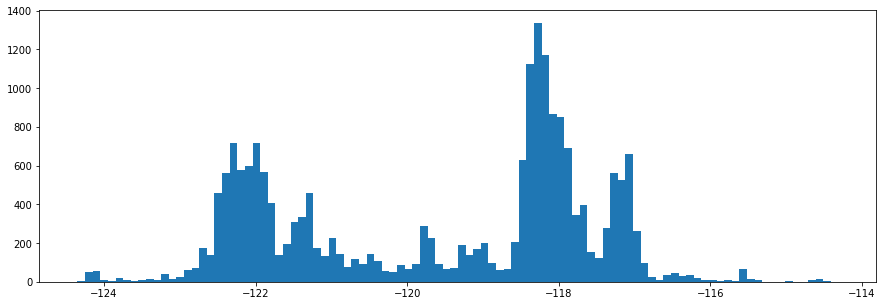

In [45]:
df_raw.longitude.hist(bins=100, grid=False, figsize=(15, 5))
print("Histograma\n")

Si quieres ver todas juntas (aunque no muy claro es una ayuda, se puede hacer el histograma de todas las variables numéricas con el siguiente pedazo de codigo:

Histogramas



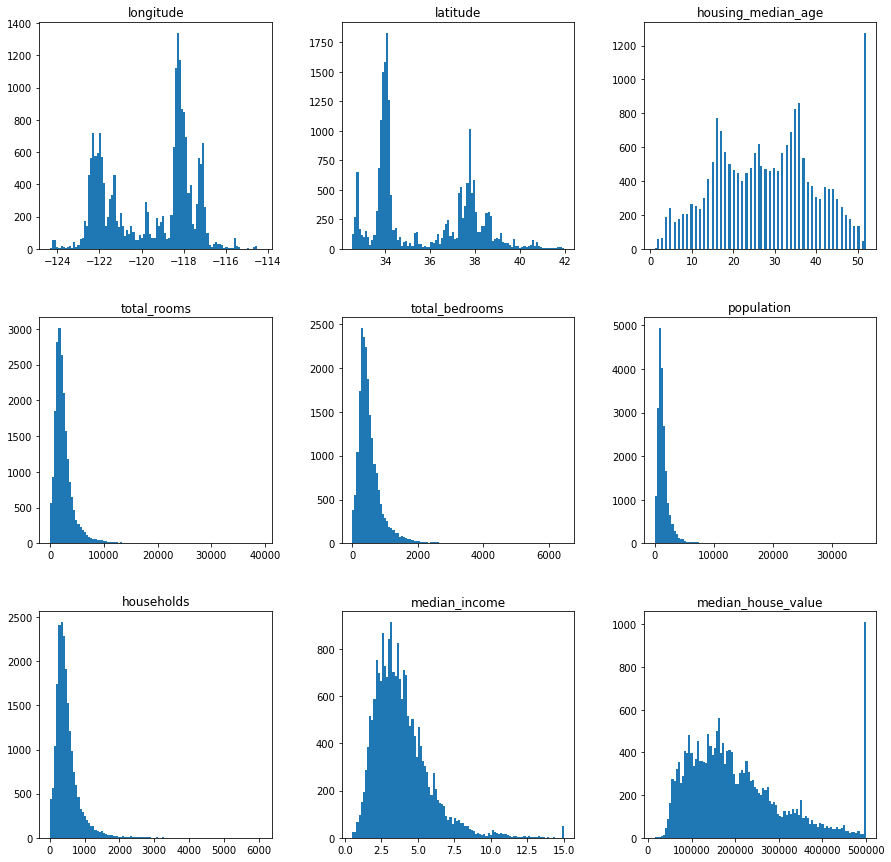

In [46]:
hists = df_raw.hist(bins=100, grid=False, figsize=(15, 15))
print("Histogramas\n")

## Tratamiento de las variables

Vamos a modificar las variables pensando en que las vamos a utilizar para desarrollar modelos de regresión y/o clasificacion, y vamos a revisar algunas técnicas.

Vamos a ir desarrollandolas paso a paso y vamos a tratar de dilucidar entre todos cual es la mejor opción para cada variables.

Recuerda, es importante saber para que lo quieres, y que técnica vas a utilizar, pero hay algunas cosas que son muy importantes para casi todo algoritmo que optimiza parámetros de un modelo basado en datos:

1. Los datos que tienen media 0 facilitan mucho el actuar de los algoritmos de optimización.

2. Tener variables que sean *adimensionales* y todas en los mismos rangos facilita el aprendizaje o el uso de métodos estadísticos (sobre todo la parte numérica pero no solamente).

3. El escalamiento facilita mucho el preprocesamiento.

4. La transformación de datos en muchas ocasiones **es parte del modelo**. El escalamiento o la transformación de variables numéricas se realiza desde la limpieza de datos, pero son al fin de cuenta modelos donde se guardan parámetros. Es una de las principales fuentes de error de muchos desarrollos tecnológicos (mas de los que podría uno creer).

5. Es importante asegurarse que no hay valores faltantes, o que los algoritmos que utilicemos sean capaces de lidiar con valores faltantes.

In [50]:
# Vamos a quedarnos con las variables numéricas solamente
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df_raw.select_dtypes(include=numerics)

#cambia los valores perdidos por 0 en todas las variables
df.fillna(0, inplace=True)

### Escalamiento

El escalamiento de puede hacer de tres maneras básicas:

1. *MinMax* 
2. *MaxAbs*
3. *Z-score* o *estandarización*



¿Cuales variables serían las mejor adaptadas para utilizar un escalamiento simple?

Vamos a probar. Revisa que pasa con los diferentes métodos.

In [ ]:
min_max = preprocessing.MinMaxScaler()
max_abs = preprocessing.MaxAbsScaler()
z_score = preprocessing.StandardScaler()

scaler = min_max

variable = 'median_house_value'
escalada = 'mhv_scaled'

df[escalada] = scaler.fit_transform(
    df[variable].values.reshape(-1, 1)
)
df[[variable, escalada]]\
    .hist(bins=100, grid=False, figsize=(15, 5))

print(scaler)
print(scaler.get_params())
print(scaler.data_min_, scaler.data_max_)

### Transformaciones logaritmica

En muchas ocasiones hay variables con comportamientos parecidos a la exponencial, por lo que un pretratamiento con el logaritmo suele mejorar mucho la distribucion de los datos.

¿En este caso en donde crees que podría aplicar:



In [ ]:
variable = 'population'
nueva = variable + " -- log"

df[nueva] = np.log(df[variable].values)

df[[variable, nueva]]\
    .hist(bins=100, grid=False, figsize=(15, 5))

## Transformación por mapeo a una distribución normal

To be continued...